In [1]:
from mattergen.diffusion.diffusion_loss import *
from mattergen.common.data.chemgraph import *
import torch

In [2]:
# First graph: identity cell
cell1 = torch.eye(3).unsqueeze(0)        # [1, 3, 3]
pos1 = torch.zeros((1, 3))               # [1, 3]
atomic_numbers1 = torch.tensor([1], dtype=torch.long)  # Hydrogen
batch1 = torch.tensor([0], dtype=torch.long)           # batch index

# Second graph: 2*identity cell
cell2 = (2 * torch.eye(3)).unsqueeze(0)  # [1, 3, 3]
pos2 = torch.zeros((1, 3))               # [1, 3]
atomic_numbers2 = torch.tensor([1], dtype=torch.long)  # Hydrogen
batch2 = torch.tensor([1], dtype=torch.long)           # batch index

# Concatenate for batch
cell = torch.cat([cell1, cell2], dim=0)               # [2, 3, 3]
pos = torch.cat([pos1, pos2], dim=0)                  # [2, 3]
atomic_numbers = torch.cat([atomic_numbers1, atomic_numbers2], dim=0)  # [2]
batch = torch.cat([batch1, batch2], dim=0)            # [2]
pbc = torch.tensor([1, 1, 1], dtype=torch.bool)        # periodic in all directions

g = ChemGraph(
    atomic_numbers=atomic_numbers,
    pos=pos.requires_grad_(True),
    cell=cell.requires_grad_(True),
    batch=batch,
    pbc=pbc
)

test = volume(g,None,30)

In [ ]:
# First graph: identity cell
cell1 = torch.eye(3).unsqueeze(0)        # [1, 3, 3]
pos1 = torch.zeros((1, 3))               # [1, 3]
atomic_numbers1 = torch.tensor([1], dtype=torch.long)  # Hydrogen
batch1 = torch.tensor([0], dtype=torch.long)           # batch index

# Second graph: 2*identity cell
cell2 = (2 * torch.eye(3)).unsqueeze(0)  # [1, 3, 3]
pos2 = torch.zeros((1, 3))               # [1, 3]
atomic_numbers2 = torch.tensor([1], dtype=torch.long)  # Hydrogen
batch2 = torch.tensor([1], dtype=torch.long)           # batch index

# Concatenate for batch
cell = torch.cat([cell1, cell2], dim=0)               # [2, 3, 3]
pos = torch.cat([pos1, pos2], dim=0)                  # [2, 3]
atomic_numbers = torch.cat([atomic_numbers1, atomic_numbers2], dim=0)  # [2]
batch = torch.cat([batch1, batch2], dim=0)            # [2]
pbc = torch.tensor([1, 1, 1], dtype=torch.bool)        # periodic in all directions

g = ChemGraph(
    atomic_numbers=atomic_numbers,
    pos=pos,
    cell=cell,
    batch=batch,
    pbc=pbc
)

print("cell:\n", g.cell)
print("batch:", g.batch)
print("volume:", torch.abs(torch.det(g.cell)))  # Should be tensor([1., 8.])

cell:
 tensor([[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[2., 0., 0.],
         [0., 2., 0.],
         [0., 0., 2.]]])
batch: tensor([0, 1])
volume: tensor([1., 8.])


In [3]:
guidance = {"volume":5.0}
loss_fn = make_combined_loss(guidance)
t=None

In [ ]:
cell_tensor = torch.tensor(
    [[[ 4.3516, -1.5141,  0.6149],
      [-1.5141,  6.1434,  0.1679],
      [ 0.6149,  0.1679,  5.4232]],

     [[ 6.2720, -0.5779,  1.0578],
      [-0.5779,  6.9124, -0.3065],
      [ 1.0578, -0.3065,  6.9619]],

     [[ 6.0133,  0.2140,  0.2133],
      [ 0.2140,  5.0960,  1.3883],
      [ 0.2133,  1.3883,  7.1379]],

     [[ 5.8231,  0.3393, -0.5104],
      [ 0.3393,  3.7942,  0.0349],
      [-0.5104,  0.0349,  4.8177]],

     [[ 4.5687,  0.6235, -1.2992],
      [ 0.6235,  5.9437,  0.6961],
      [-1.2992,  0.6961,  7.0461]]], device='cuda:0', requires_grad=True
)

pos_tensor = torch.tensor(
    [[0.1310, 0.9461, 0.7470],
     [0.4265, 0.1370, 0.1155],
     [0.9801, 0.0569, 0.0659],
     [0.8773, 0.0013, 0.9509],
     [0.5542, 0.5153, 0.7079],
     [0.9035, 0.7442, 0.4594],
     [0.9149, 0.1001, 0.9507],
     [0.3755, 0.4562, 0.8747],
     [0.1470, 0.2804, 0.4319],
     [0.6593, 0.6515, 0.3958],
     [0.3811, 0.9338, 0.4557],
     [0.0914, 0.7402, 0.1936],
     [0.6704, 0.9788, 0.4947],
     [0.4495, 0.4411, 0.0278],
     [0.8079, 0.6355, 0.4580],
     [0.9581, 0.0243, 0.2232],
     [0.2198, 0.3100, 0.4565],
     [0.9197, 0.3020, 0.3068],
     [0.4468, 0.6582, 0.9835],
     [0.3606, 0.5917, 0.1846],
     [0.4044, 0.1283, 0.0664],
     [0.6070, 0.2345, 0.2315],
     [0.1035, 0.2380, 0.7021],
     [0.2375, 0.0644, 0.8052],
     [0.3153, 0.2525, 0.7850],
     [0.5986, 0.3825, 0.3735],
     [0.8002, 0.8277, 0.5344],
     [0.0336, 0.7086, 0.8363],
     [0.3363, 0.3324, 0.0386],
     [0.1602, 0.4362, 0.1427],
     [0.4245, 0.2435, 0.4621],
     [0.8812, 0.3093, 0.1818],
     [0.0933, 0.5245, 0.1296],
     [0.0288, 0.3235, 0.9353],
     [0.3725, 0.8614, 0.6027],
     [0.4180, 0.9526, 0.2075],
     [0.5338, 0.0342, 0.6897],
     [0.1304, 0.3942, 0.8355],
     [0.3617, 0.0796, 0.9171],
     [0.2735, 0.9155, 0.5862],
     [0.2335, 0.8733, 0.0771],
     [0.4929, 0.7656, 0.8187],
     [0.1524, 0.1886, 0.5731],
     [0.1533, 0.0940, 0.1612],
     [0.5566, 0.1702, 0.6329],
     [0.0290, 0.9601, 0.7891],
     [0.4740, 0.2412, 0.8689],
     [0.2413, 0.8498, 0.2300],
     [0.7346, 0.6523, 0.9365],
     [0.2465, 0.2853, 0.0799],
     [0.9466, 0.6985, 0.2798],
     [0.5104, 0.7481, 0.7046],
     [0.9831, 0.9127, 0.1403],
     [0.6480, 0.4283, 0.1882],
     [0.2928, 0.3257, 0.0968],
     [0.0296, 0.1578, 0.6829],
     [0.2803, 0.6835, 0.9186]], device='cuda:0', requires_grad=True
)

# Example atomic_numbers, batch, and pbc for demonstration
atomic_numbers = torch.ones(pos_tensor.shape[0], dtype=torch.long, device='cuda:0')
batch = torch.zeros(pos_tensor.shape[0], dtype=torch.long, device='cuda:0')
pbc = torch.tensor([True, True, True], device='cuda:0')

x = ChemGraphBatch(
    atomic_numbers=atomic_numbers,
    pos=pos_tensor,
    cell=cell_tensor,
    batch=batch,
    pbc=pbc
)

In [5]:
scores = {
    'cell': torch.tensor([[[ 0.9351,  1.3775, -0.5692],
                          [ 1.3775, -0.6458, -0.1520],
                          [-0.5692, -0.1520, -0.0249]],

                         [[ 0.1604,  0.3677, -0.6655],
                          [ 0.3677, -0.2679,  0.1940],
                          [-0.6655,  0.1940, -0.2698]],

                         [[-0.3833, -0.1860, -0.1694],
                          [-0.1860,  0.4003, -1.1894],
                          [-0.1694, -1.1894, -1.3410]],

                         [[ 0.0578, -0.2550,  0.3932],
                          [-0.2550,  1.6095, -0.0382],
                          [ 0.3932, -0.0382,  0.8575]],

                         [[ 0.8639, -0.5432,  1.1023],
                          [-0.5432, -0.3252, -0.5981],
                          [ 1.1023, -0.5981, -1.2547]]], device='cuda:0'),
    'pos': torch.tensor([[-0.0142, -0.0097, -0.0061],
                         [-0.0111, -0.0079, -0.0057],
                         [-0.0106, -0.0072, -0.0058],
                         [-0.0114, -0.0081, -0.0065],
                         [-0.0085, -0.0064, -0.0074],
                         [-0.0100, -0.0059, -0.0054],
                         [-0.0089, -0.0071, -0.0061],
                         [-0.0108, -0.0078, -0.0062],
                         [-0.0094, -0.0076, -0.0063],
                         [-0.0048, -0.0034, -0.0028],
                         [-0.0058, -0.0058, -0.0040],
                         [-0.0055, -0.0055, -0.0044],
                         [-0.0042, -0.0033, -0.0032],
                         [-0.0043, -0.0043, -0.0048],
                         [-0.0062, -0.0054, -0.0036],
                         [-0.0052, -0.0042, -0.0034],
                         [-0.0047, -0.0034, -0.0020],
                         [-0.0043, -0.0024, -0.0024],
                         [-0.0046, -0.0046, -0.0053],
                         [-0.0039, -0.0035, -0.0034],
                         [-0.0031, -0.0034, -0.0054],
                         [-0.0037, -0.0031, -0.0029],
                         [-0.0044, -0.0028, -0.0027],
                         [-0.0041, -0.0042, -0.0036],
                         [-0.0033, -0.0028, -0.0038],
                         [-0.0113, -0.0064, -0.0036],
                         [-0.0097, -0.0085, -0.0043],
                         [-0.0102, -0.0083, -0.0059],
                         [-0.0066, -0.0073, -0.0040],
                         [-0.0083, -0.0071, -0.0056],
                         [-0.0106, -0.0089, -0.0049],
                         [-0.0086, -0.0065, -0.0058],
                         [-0.0105, -0.0067, -0.0045],
                         [-0.0085, -0.0071, -0.0052],
                         [-0.0079, -0.0068, -0.0049],
                         [-0.0069, -0.0048, -0.0048],
                         [-0.0042, -0.0029, -0.0040],
                         [-0.0026, -0.0034, -0.0032],
                         [-0.0059, -0.0026, -0.0019],
                         [-0.0059, -0.0068, -0.0043],
                         [-0.0035, -0.0059, -0.0040],
                         [-0.0031, -0.0054, -0.0025],
                         [-0.0044, -0.0054, -0.0042],
                         [-0.0032, -0.0045, -0.0032],
                         [-0.0050, -0.0024, -0.0040],
                         [-0.0025, -0.0043, -0.0028],
                         [-0.0041, -0.0022, -0.0041],
                         [-0.0112, -0.0083, -0.0051],
                         [-0.0101, -0.0087, -0.0054],
                         [-0.0102, -0.0067, -0.0051],
                         [-0.0090, -0.0082, -0.0044],
                         [-0.0097, -0.0068, -0.0055],
                         [-0.0123, -0.0066, -0.0052],
                         [-0.0096, -0.0094, -0.0043],
                         [-0.0097, -0.0080, -0.0048],
                         [-0.0127, -0.0073, -0.0058],
                         [-0.0126, -0.0077, -0.0064]], device='cuda:0')
}

In [ ]:
replace_kwargs = ["pos", "cell"]
            # Create a new ChemGraphBatch with requires_grad=True for pos and cell         
x_for_grad = ChemGraphBatch(
                atomic_numbers=x.atomic_numbers,
                pos=x.pos.clone().detach().requires_grad_(True),
                cell=x.cell.clone().detach().requires_grad_(True),
                batch=x.batch,
            )
print("cell:", x_for_grad.cell.requires_grad, "\n", "pos:", x_for_grad.pos.requires_grad)

grad_dict = {}
diffusion_loss = loss_fn(x_for_grad, t)
print("Diffusion loss:", diffusion_loss)
for field in replace_kwargs:
    grad = torch.autograd.grad(
        diffusion_loss, getattr(x_for_grad, field),
        grad_outputs=torch.ones_like(diffusion_loss),
        create_graph=True,
        allow_unused=True
    )[0]
    if grad is None:
        grad = torch.zeros_like(getattr(x_for_grad, field))
    print(f"Gradient for {field}:", grad)
    grad_dict[field] = grad

print("------------------------------\n",
      "Diffusion loss gradient:", grad_dict, "\n",
      "Diffusion loss function:", loss_fn(x_for_grad, None), "\n",
      loss_fn, "\n------------------------------")
for k in grad_dict:
    if k in scores:
        scores[k] = scores[k] - grad_dict[k]

In [23]:
x_for_grad.cell.requires_grad

True

In [3]:
import json
import torch

with open('/Data/auguste.de-lambilly/mattergenbis/results/chemical_system/Pd-Ni-H_test/diffusion_loss_history.txt', 'r') as f:
    data = json.load(f)

# If the file contains a list of lists (matrix), convert to torch.Tensor or numpy array if needed
matrix = torch.tensor(data)
print(matrix.shape)

torch.Size([4000, 20])


In [5]:
matrix[0]

tensor([ 67.0062,  36.2429,  48.4705,  97.1003,  60.9496, 111.4470,  36.8407,
         24.4717,  73.3281,  36.8552,  48.6143,  72.6548,  97.7546,  30.4708,
         57.4685,  85.0670,  24.5908,  24.5269,  61.0951, 108.7337])

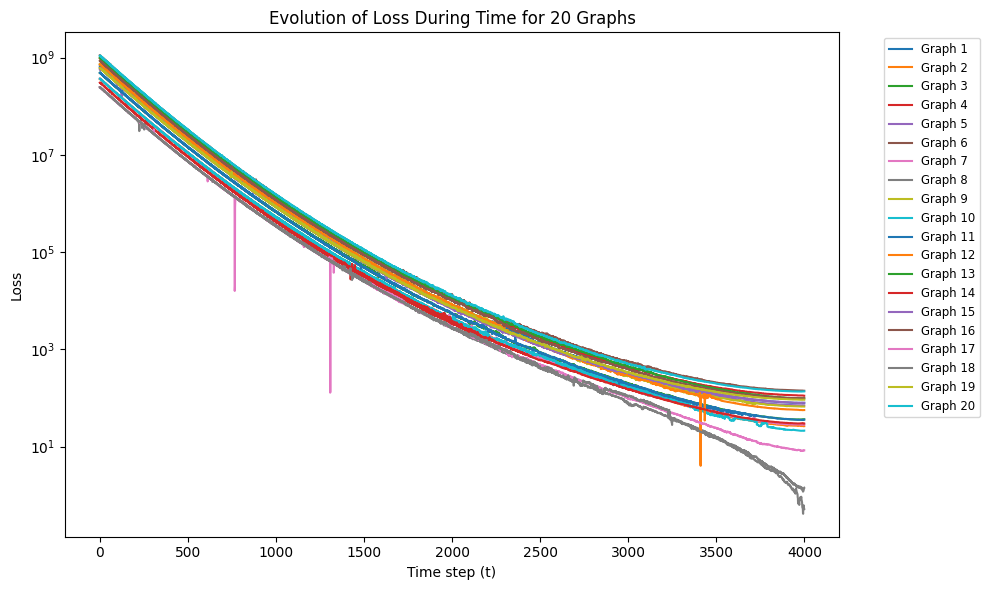

In [8]:
import matplotlib.pyplot as plt

# Plot the first 20 rows of matrix as loss curves over time with log scale on y-axis
plt.figure(figsize=(10, 6))
for i in range(20):
    plt.plot(10**7*matrix[:,i].cpu().numpy(), label=f'Graph {i+1}')
plt.xlabel('Time step (t)')
plt.ylabel('Loss')
plt.title('Evolution of Loss During Time for 20 Graphs')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()